In [1]:
import numpy as np
import pandas as pd
from os import path
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch
from torchvision import transforms, models

In [2]:
# Check if GPU is available
torch.cuda.is_available()

True

In [17]:
# Load and preprocess data
training = pd.read_csv('training.csv')
testing = pd.read_csv('test.csv')

# Input -1 for missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)

# Convert back to dataframe and replace the missing values
training = pd.DataFrame(imputer.fit_transform(training), columns=training.columns)

# Extract target columns (first 30 columns for 15 keypoints)
y_training = training.iloc[:, :30]

# Get the last feature column
lastFeature = training.iloc[:, -1]

# Split the last feature by spaces
splitFeatures = lastFeature.str.split(' ', expand=True)

# Drop the original last feature and concatenate the new split features
training = pd.concat([training.drop(training.columns[-1], axis=1), splitFeatures], axis=1)

# Drop the first columns here so they aren't mislabeled, and this way we can just make this the X_train
training.drop(training.columns[range(0, 30)], axis=1, inplace=True)

# Rename the columns to pixel_i
training.columns = [f'pixel_{i}' for i in range(training.shape[1])]

# Same for testing
testImg = testing.iloc[:, -1]
splitTest = testImg.str.split(' ', expand=True)
testing = pd.concat([testing.drop(testing.columns[-1], axis=1), splitTest], axis=1)

# There was an extra column that was just the index
testing.drop(columns=testing.columns[[0]], inplace=True)

# Rename the columns to pixel_i
testing.columns = ['ImageId'] + [f'pixel_{i}' for i in range(1, testing.shape[1])]

# Split data into train and test splits
X_train, X_test, y_train, y_test = train_test_split(training, y_training, train_size=0.8, test_size=0.2, random_state=10)

# Reshape dataframe into numpy array so I can reshape it again
X_train = X_train.to_numpy(dtype=np.float32)

# Reshape image data so the model can process it as a Tensor
X_train = X_train.reshape(-1, 1, 96, 96)
X_train = X_train / 255.0

# Reshape y_train into a numpy array as well
y_train = np.array(y_train, dtype=np.float32)

# Reshape test data
X_test = X_test.to_numpy(dtype=np.float32)
X_test = X_test.reshape(-1, 1, 96, 96)
X_test = X_test / 255.0

y_test = np.array(y_test, dtype=np.float32)
print(X_train.shape)

# Define data augmentation transformations
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))], p=0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5)], p=0.5),
    transforms.RandomApply([transforms.RandomInvert()], p=0.5),
    transforms.ToTensor(),
    transforms.RandomApply([transforms.Lambda(lambda x: x + 0.05 * torch.randn_like(x))], p=0.5)  # Add random noise
])

# Apply data augmentation to training data
augmented_images = []
for img in X_train:
    img = img.squeeze()  # Remove channel dimension
    img = data_transforms(img)
    augmented_images.append(img.numpy())

X_train_aug = np.array(augmented_images).reshape(-1, 1, 96, 96)

# Define additional data augmentation transformations
additional_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor()
])

# Adjust y_train, X_test, and y_test
y_train = y_train.reshape(-1, 30)
X_test = X_test.reshape(-1, 1, 96, 96)
y_test = y_test.reshape(-1, 30)

# Apply additional data augmentation to training data
augmented_images = []
for img in X_train:
    img = img.squeeze()  # Remove channel dimension
    img = additional_transforms(img)
    augmented_images.append(img.numpy())

X_train_aug = np.array(augmented_images).reshape(-1, 1, 96, 96)
# Combine original and augmented data
X_train = np.concatenate((X_train, X_train_aug), axis=0)
y_train = np.concatenate((y_train, y_train), axis=0)


(5639, 1, 96, 96)


In [24]:
class ImprovedCnnModel(nn.Module):
    def __init__(self):
        super(ImprovedCnnModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 6 * 6, 512)  # Adjusted for 96x96 input
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 30)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 6 * 6)
        x = F.relu(self.bn2(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Convert data to PyTorch tensors and create DataLoader
xTrainTensor = torch.tensor(X_train.reshape(-1, 1, 96, 96), dtype=torch.float32)
yTrainTensor = torch.tensor(y_train, dtype=torch.float32)
trainDataset = TensorDataset(xTrainTensor, yTrainTensor)
trainLoader = DataLoader(trainDataset, batch_size=24, shuffle=True)

# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImprovedCnnModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

modelPath = 'models/cnn100.pth'

numEpochs = 100
for epoch in range(numEpochs):
    model.train()
    runningLoss = 0.0
    for inputs, targets in trainLoader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        runningLoss += loss.item()
    
    print(f'Epoch {epoch+1}/{numEpochs}, Loss: {runningLoss/len(trainLoader)}')

Epoch 1/100, Loss: 1097.4281922685338
Epoch 2/100, Loss: 705.3361752124542
Epoch 3/100, Loss: 457.9799687162359
Epoch 4/100, Loss: 290.4919206659845
Epoch 5/100, Loss: 184.72200380690555
Epoch 6/100, Loss: 119.77746901004872
Epoch 7/100, Loss: 89.5279270253283
Epoch 8/100, Loss: 72.24739739032502
Epoch 9/100, Loss: 65.61289965852778
Epoch 10/100, Loss: 57.226670313896015
Epoch 11/100, Loss: 52.29140307243834
Epoch 12/100, Loss: 53.19494609021126
Epoch 13/100, Loss: 52.448646111183976
Epoch 14/100, Loss: 52.344486289328714
Epoch 15/100, Loss: 48.52590768895251
Epoch 16/100, Loss: 48.9280996261759
Epoch 17/100, Loss: 47.92290143560856
Epoch 18/100, Loss: 48.22854533905679
Epoch 19/100, Loss: 47.453094701564055
Epoch 20/100, Loss: 44.85718173371985
Epoch 21/100, Loss: 45.59561741605718
Epoch 22/100, Loss: 45.03263365968745
Epoch 23/100, Loss: 43.950017269621505
Epoch 24/100, Loss: 42.242783266432745
Epoch 25/100, Loss: 44.36353968965246
Epoch 26/100, Loss: 42.081152573037656
Epoch 27/100,

In [25]:
# Evaluation
X_test_tensor = torch.tensor(X_test.reshape(-1, 1, 96, 96), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

y_pred = y_pred_tensor.cpu().numpy()
mse2 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse2}')

Mean Squared Error (MSE): 110.97185516357422


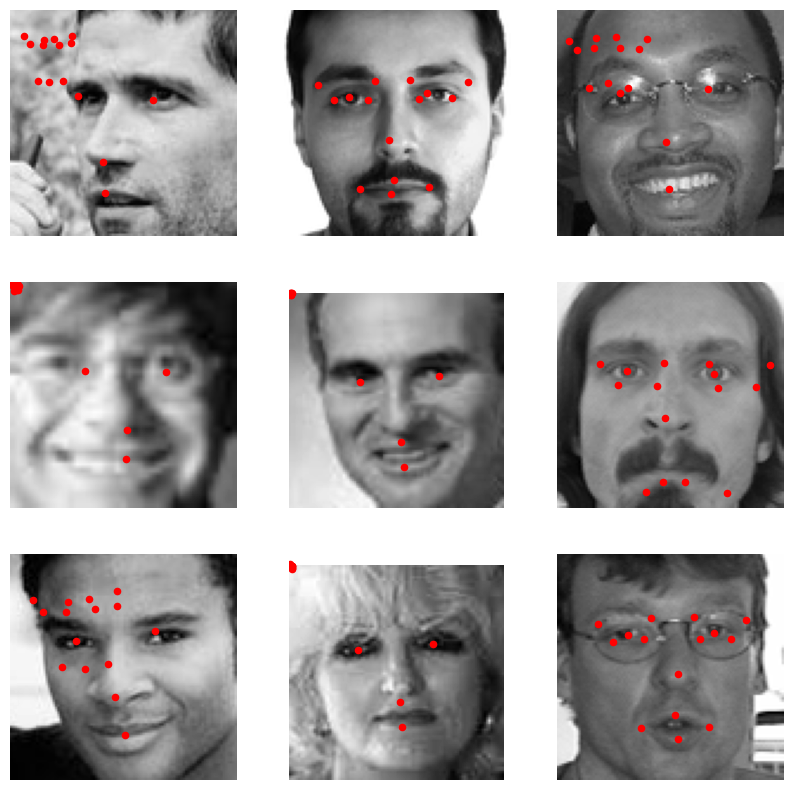

In [26]:
import matplotlib.pyplot as plt

def showPrediction(image, keypoints, size, idx): # Shows the image with the predicted keypoints
    plt.subplot(int(size ** 0.5), int(size ** 0.5), idx + 1)
    plt.imshow(image, cmap='gray')
    for i in range(0, len(keypoints), 2):
        plt.scatter(keypoints[i], keypoints[i+1], c='red', s=20)
    plt.axis('off')

X_test = X_test.reshape(-1, 96, 96)

plt.figure(figsize=(10, 10))
for idx in range(20, 29):
    showPrediction(X_test[idx], y_pred[idx], 9, idx - 20)
plt.show()